# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

# Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
# If Jedi's not working
%config Completer.use_jedi = False

In [3]:
# Point this to where you stored the MOESM data:
DATA = Path('/data2/drugdiscovery/MOESM')

In [4]:
IMGDATA = Path('/data-ext-10tb/ubuntu/MOESM/molimages')

In [5]:
NB_DIR = Path.cwd()
LOCALDATA = NB_DIR/'dev-notebooks'/'data'/'drug'/'interim'

In [6]:
from fastai.vision.all import *

# Load data

In [7]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [8]:
# Datasets available:
data = sorted(list(DATA.glob('CHEM*cl.csv')))
data

[Path('/data2/drugdiscovery/MOESM/CHEMBL1978_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL205_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL218_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL219_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL240_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL244_cl.csv'),
 Path('/data2/drugdiscovery/MOESM/CHEMBL301_cl.csv')]

...and that we've generated images of the molecules:

In [9]:
IMGDATA.ls()

(#7) [Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL240_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL244_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL301_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL218_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL1978_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL205_cl'),Path('/data-ext-10tb/ubuntu/MOESM/molimages/CHEMBL219_cl')]

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [10]:
ds = data[0]
ds

Path('/data2/drugdiscovery/MOESM/CHEMBL1978_cl.csv')

In [11]:
df, name = get_df(ds)

In [12]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       6831 non-null   object
 1   SMILES    6831 non-null   object
 2   Image     6831 non-null   object
 3   Activity  6831 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 213.6+ KB


In [14]:
df['Activity'].value_counts()

0    6210
1     621
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [17]:
df = val_cols_and_oversample(df)

In [18]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False
1,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False
2,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False
3,CHEMBL1957218,s1cc(nc1-c1ccncc1C)-c1cccnc1,CHEMBL1957218.png,1,False
4,CHEMBL1957223,s1cc(nc1-c1cccnc1)-c1ccc(OC)nc1,CHEMBL1957223.png,1,False


In [19]:
df['Activity'].value_counts()

0    6210
1    4815
Name: Activity, dtype: int64

# Create a dataloader

In [20]:
bs=64

In [21]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [22]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [23]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

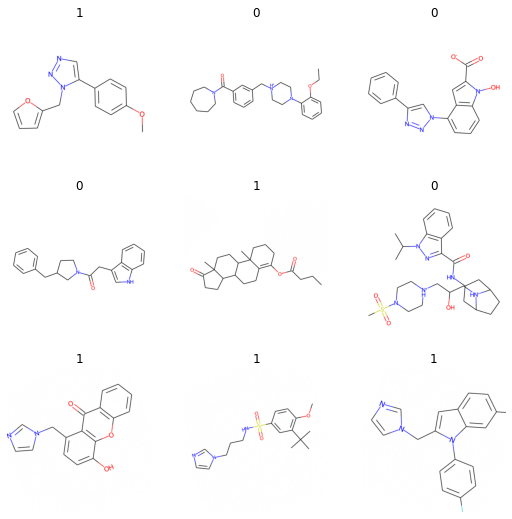

In [24]:
dls.show_batch()

# Train a CNN

In [25]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [26]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [27]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [28]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

The below training takes a while. We can rather load the results of a previous run:

In [31]:
learn = learn.load('chembl1978-model-test-hooks')

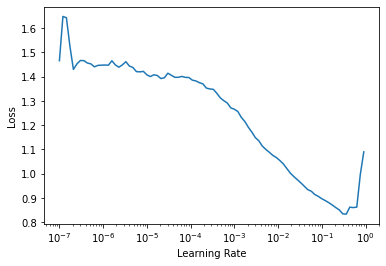

In [29]:
lr_min, _ = learn.lr_find(suggestions=True)

In [30]:
lr_min

0.03630780577659607

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.309027,0.222809,0.911007,0.648148,0.505415,0.903226,0.962042,0.635118,00:37
1,0.215386,0.121588,0.964871,0.810127,0.795031,0.825806,0.970554,0.790953,00:36
2,0.158347,0.365355,0.884075,0.604000,0.437681,0.974194,0.977488,0.607634,00:36
3,0.133653,0.131030,0.953747,0.784741,0.679245,0.929032,0.981767,0.771226,00:37
4,0.121126,0.092991,0.974824,0.864353,0.845679,0.883871,0.981646,0.850737,00:37
5,0.105937,0.089018,0.977166,0.873786,0.876623,0.870968,0.980649,0.861240,00:36
6,0.079080,0.104706,0.971897,0.854545,0.805714,0.909677,0.982992,0.840948,00:36
7,0.052114,0.103751,0.978337,0.881789,0.873418,0.890323,0.981736,0.869915,00:36
8,0.047780,0.102470,0.974824,0.866873,0.833333,0.903226,0.984058,0.853839,00:36
9,0.040300,0.101220,0.976581,0.876543,0.840237,0.916129,0.984521,0.864619,00:36


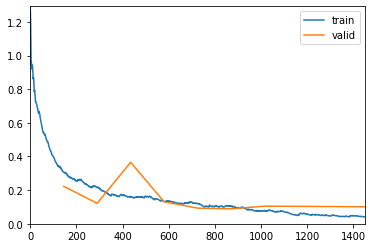

In [31]:
learn.fit_one_cycle(10, slice(lr_min))

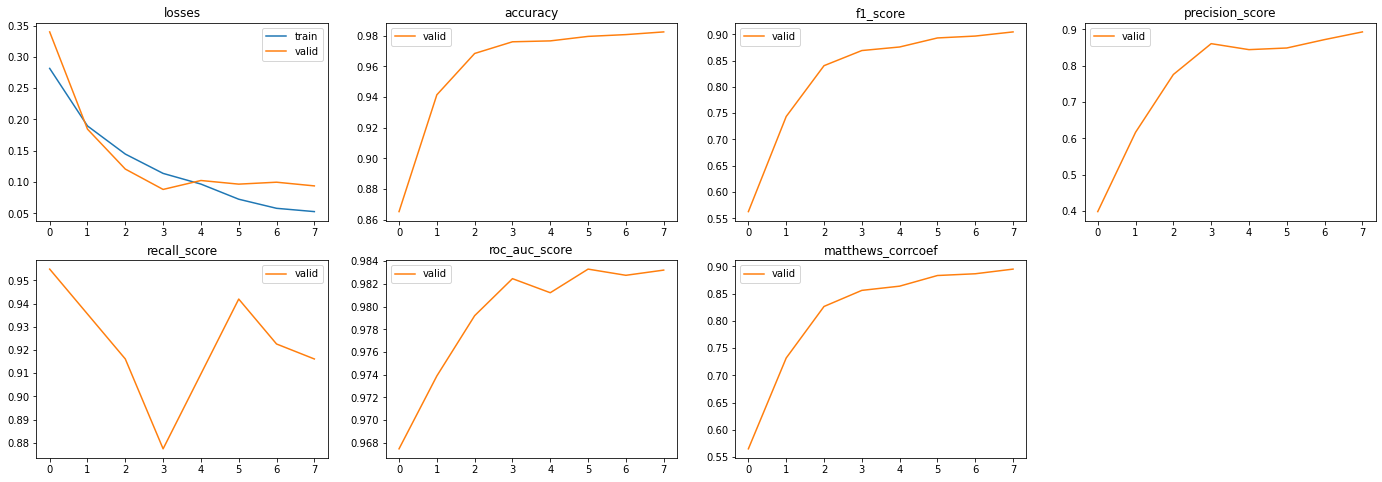

In [45]:
learn.recorder.plot_metrics()

In [32]:
learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


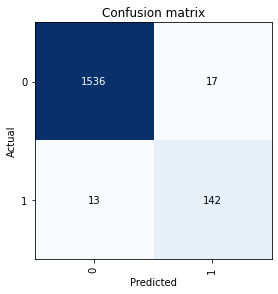

In [48]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a "hook" at the layer we want to save activations from:

In [49]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [50]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [51]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [52]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [53]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [54]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [55]:
test_df = test_dls.items.reset_index()

In [56]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,4056,CHEMBL44179,O(C)c1ccccc1NC(=O)CCCCCCC\C=C\CCCCCCCC,CHEMBL44179.png,0,False
1,2022,CHEMBL2179491,S(=O)(=O)(C)c1cc2c3CCCCc3n(c2cc1)CCCS(=O)(=O)N(C)C,CHEMBL2179491.png,0,False
2,4080,CHEMBL210655,O(C)c1ccccc1CC(=O)Nc1[nH+]c(OCC)c(C#N)c(N)c1,CHEMBL210655.png,0,False
3,3119,CHEMBL26521,O=C1NC2C(N1C1CC[NH+](CC1)Cc1ccccc1)CCCC2,CHEMBL26521.png,0,False
4,4750,CHEMBL526083,Fc1ccc(cc1)-c1ncc(nc1)C(=O)Nc1cc2[nH]c(nc2cc1)N(C(C)C)C,CHEMBL526083.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [57]:
test_dls.dataset[0]

(PILImage mode=RGB size=500x500, TensorCategory(0))

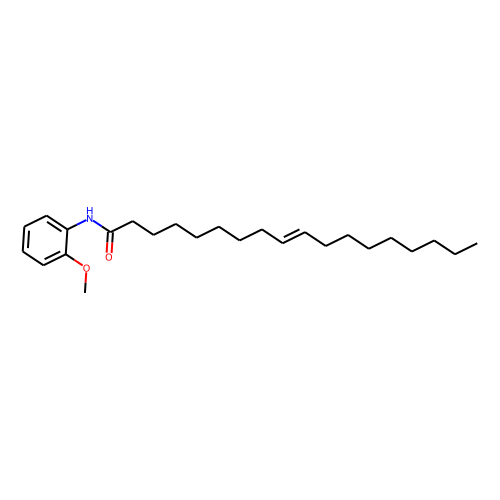

In [58]:
test_dls.dataset[0][0]

In [59]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [60]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [34]:
df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')

In [61]:
#%%time
#%%capture
#df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

CPU times: user 17min 32s, sys: 52.4 s, total: 18min 24s
Wall time: 2min 18s


Now we've stored activations for each image:

In [36]:
#df_nodupl.head()

We split the activations to have one column for each, as they will be treated as separate features later:

In [63]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [64]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [37]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,3.485569,1.898547,-38.878273,7.912410,-30.636671,...,-26.087261,10.845460,-16.769337,-27.859449,22.668242,9.978525,20.189241,29.793533,11.848484,22.452715
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,-2.217715,10.761065,-52.895351,-2.844842,-13.003623,...,-4.451060,17.848938,-31.413528,-10.253824,25.925531,-5.185490,9.071753,43.889679,17.232124,35.617458
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,5.656251,4.901986,-49.849308,14.309812,-13.939421,...,-12.291193,20.940042,7.085035,-23.009224,30.580616,5.500651,27.811693,34.743080,-0.426268,14.223265
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,11.196653,10.385941,-20.909716,5.669860,-33.497929,...,-30.099443,10.059969,-16.107344,-23.143013,32.467686,18.741871,15.052759,50.799931,2.927256,27.810600
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,2.815598,14.836289,-14.933740,-2.783419,-34.052666,...,-24.011885,18.602715,-16.238585,-25.184177,41.306664,-1.612225,17.429197,53.076782,-0.566382,34.914177


In [66]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: float64(128), int64(1), object(4)
memory usage: 6.9+ MB


In [67]:
#df_acts.to_csv('data/chembl1978_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `dev-noteboos/DL-Example-3-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [38]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [39]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


In [41]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: bool(1), float64(128), int64(1), object(3)
memory usage: 6.9+ MB


In [42]:
df = df_ecfp.merge(df_acts, on='CID')

In [43]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-26.087261,10.845460,-16.769337,-27.859449,22.668242,9.978525,20.189241,29.793533,11.848484,22.452715
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,-4.451060,17.848938,-31.413528,-10.253824,25.925531,-5.185490,9.071753,43.889679,17.232124,35.617458
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-12.291193,20.940042,7.085035,-23.009224,30.580616,5.500651,27.811693,34.743080,-0.426268,14.223265
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-30.099443,10.059969,-16.107344,-23.143013,32.467686,18.741871,15.052759,50.799931,2.927256,27.810600
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-24.011885,18.602715,-16.238585,-25.184177,41.306664,-1.612225,17.429197,53.076782,-0.566382,34.914177


In [44]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [45]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-26.087261,10.845460,-16.769337,-27.859449,22.668242,9.978525,20.189241,29.793533,11.848484,22.452715
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,-4.451060,17.848938,-31.413528,-10.253824,25.925531,-5.185490,9.071753,43.889679,17.232124,35.617458
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,-12.291193,20.940042,7.085035,-23.009224,30.580616,5.500651,27.811693,34.743080,-0.426268,14.223265
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-30.099443,10.059969,-16.107344,-23.143013,32.467686,18.741871,15.052759,50.799931,2.927256,27.810600
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-24.011885,18.602715,-16.238585,-25.184177,41.306664,-1.612225,17.429197,53.076782,-0.566382,34.914177


In [46]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [47]:
LOCALDATA

Path('/home/ubuntu/Dropbox/medGPU-alex/DLN-AI-2021-dev/MMIV-DLN-AI-2021/1-deep_learning/dev-notebooks/data/drug/interim')

In [48]:
df.to_csv(LOCALDATA/'chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [49]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [50]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [51]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [52]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,-4.451060,17.848938,-31.413528,-10.253824,25.925531,-5.185490,9.071753,43.889679,17.232124,35.617458
3,0,0,0,0,0,0,0,0,0,0,...,-30.099443,10.059969,-16.107344,-23.143013,32.467686,18.741871,15.052759,50.799931,2.927256,27.810600
4,0,0,0,0,0,0,0,0,0,0,...,-24.011885,18.602715,-16.238585,-25.184177,41.306664,-1.612225,17.429197,53.076782,-0.566382,34.914177
5,0,0,0,0,0,0,0,0,0,0,...,-24.548574,29.396210,-27.249018,-26.106590,34.966820,-4.800174,32.564442,47.004269,8.783585,33.251316
8,0,0,0,0,0,0,0,0,0,0,...,-16.842392,33.022118,-12.352568,-29.601570,10.848252,4.141723,10.873550,13.986954,14.547134,4.099521


In [53]:
y_train.head()

1    1
3    1
4    1
5    1
8    1
Name: Activity, dtype: int64

### Logistic Regression and Random forest

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [55]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [56]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [57]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=100)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [58]:
train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features



(0.9844421826641464,
 0.9754098360655737,
 0.8518754972513235,
 0.8709677419354839,
 0.8598726114649682,
 0.8653846153846154,
 LogisticRegression(max_iter=500))

In [59]:
train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features



(0.9810813617763745,
 0.9707259953161592,
 0.8161893121465061,
 0.7935483870967742,
 0.8723404255319149,
 0.8310810810810813,
 LogisticRegression(max_iter=500))

In [60]:
train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features



(0.9854807552499844,
 0.9771662763466042,
 0.8597379762105276,
 0.8580645161290322,
 0.8866666666666667,
 0.8721311475409836,
 LogisticRegression(max_iter=500))

**Random forest:**

In [61]:
train_rf(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features



(0.9922896371227384,
 0.9795081967213115,
 0.8705086999500459,
 0.8193548387096774,
 0.9477611940298507,
 0.8788927335640139,
 RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                        random_state=100))

In [62]:
train_rf(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features



(0.9770620858691814,
 0.9742388758782201,
 0.8390791502712486,
 0.8193548387096774,
 0.8881118881118881,
 0.8523489932885905,
 RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                        random_state=100))

In [63]:
train_rf(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features



(0.9761107533805538,
 0.9754098360655737,
 0.8464380197438741,
 0.8258064516129032,
 0.8951048951048951,
 0.8590604026845637,
 RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                        random_state=100))